# n_qubits_QVC_Moons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn import svm

import scikitplot as skplt

from h import *
from W_unitary import *
from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

### helper functions

In [2]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def training_split(X_train, y_train, n_batches):
    
    if len(X_train)%n_batches == 0:
        
        X_batches = np.split(X_train, n_batches)
        y_batches = np.split(y_train, n_batches)
        
    else:
        print('Warning: the training set must be divided into equally sized batches')
    
    return X_batches, y_batches


def k_fold_split(X, y, ele_per_split, i):
    
    k_X_train = np.concatenate( (X[:ele_per_split*i, :], X[ele_per_split*(i+1):, :]) )
    k_X_test = X[ele_per_split*i:ele_per_split*(i+1), :]
    
    k_y_train = np.concatenate( (y[:ele_per_split*i], y[ele_per_split*(i+1):]) )
    k_y_test = y[ele_per_split*i:ele_per_split*(i+1)]
    
    return k_X_train, k_X_test, k_y_train, k_y_test

### dataset

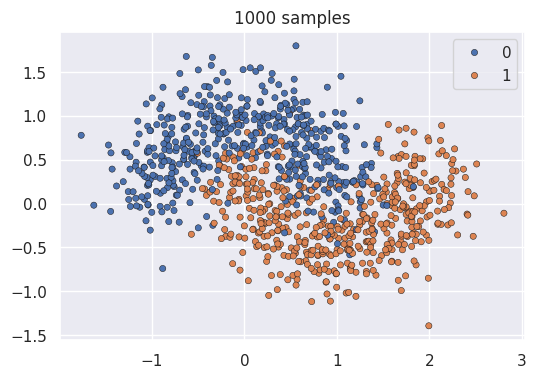

In [3]:
n_samples = 1000
X, y = make_moons(n_samples, noise=0.3)

s = 20
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=s, edgecolor="k", legend=True).set_title(str(n_samples) +" samples")
plt.savefig('Moons_plot.pdf')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

n_batches = 7
X_batches, y_batches = training_split(X_train, y_train, n_batches)

## Classical SVM

### linear kernel

In [4]:
linear_kernel = svm.LinearSVC()
linear_kernel.fit(X_train, y_train);

/home/pschaefers/master/QCQP/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


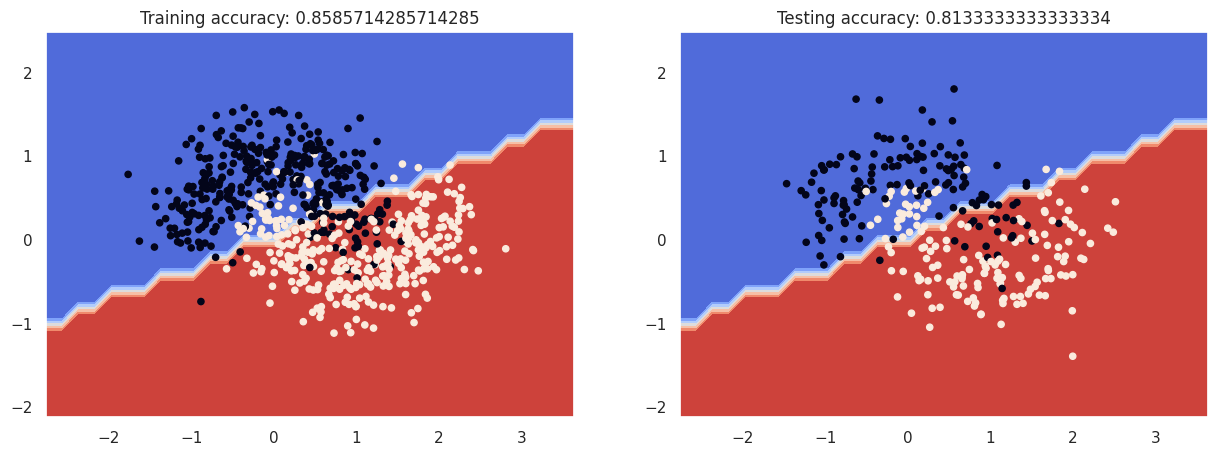

In [5]:
accuracy_train = linear_kernel.score(X_train, y_train)
accuracy_test = linear_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = linear_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x0x0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, s=s, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], s=s, c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

plt.savefig('Moons_linear.pdf')

### gaussian kernel

In [6]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

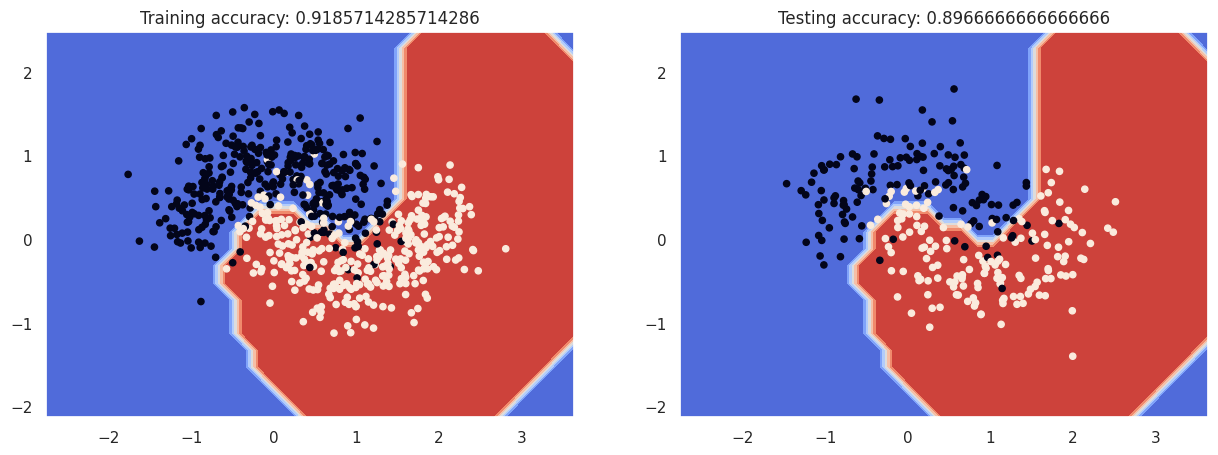

In [7]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = gaussian_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x1x1.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, s=s, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], s=s, c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

plt.savefig('Moons_gaussian.pdf')

## Quantum SVM (explicit approach)

In [8]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 2
d = 2

init_theta = 2*np.pi*np.random.random(n*d*3)
print('Initial parameters: '+ str(init_theta))

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]


#### training

In [9]:
def MSE_loss(theta, data, labels):
    
    tmp = []
    for i in range(0, len(labels)):
        if labels[i] == 0:
            tmp.append(-1)
        else:
            tmp.append(1)
    
    predictions = []
    for i in range(0, len(labels)):
        predictions.append(h(data[i], theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - tmp[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    
    return norm

In [10]:
epochs = n_batches
shots = 1024
theta = init_theta
thetas = []
predictions = []
training_accuracies = []
testing_accuracies = []

for i in tqdm(range(0, epochs)):
    
    prediction = np.zeros(len(y_batches[i]))
    data = X_batches[i]
    labels = y_batches[i]
    
    for j in range(0, len(data)):
        prediction[j] = h(data[j], theta, n, d, shots)
        
        objective_function = lambda theta: MSE_loss(theta, data, labels)
        optimizer = COBYLA(maxiter=100)
        
        theta_opt = optimizer.minimize(objective_function, theta).x
    
    h_subtest = np.zeros(len(y_test))
    for j in range(0, len(y_test)):
        h_subtest[j] = h(X_test[j], theta_opt, n, d, shots)
    
    train_result = 1 - ( (np.abs((sum(2*labels-1-prediction))/2)) / len(labels) )
    test_result = 1 - ( np.abs((sum(2*y_test-1-h_subtest)/2)) / len(y_test) )
    training_accuracies.append(train_result)
    testing_accuracies.append(test_result)
    
    thetas.append(theta_opt)
    predictions.append(prediction)
    theta = theta_opt

  0%|          | 0/7 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
  0%|          | 0/7 [33:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print('Training accuracies: '+ str(training_accuracies))
print('Training mean: '+ str(np.mean(training_accuracies)))
print('Testing accuracies: '+ str(testing_accuracies))
print('Testing mean: '+ str(np.mean(testing_accuracies)))

In [ ]:
plt.plot(training_accuracies, color='blue', label='training')
plt.plot(testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('epochs')
plt.ylabel('accuracies')
plt.legend(loc=0, frameon=False)
plt.savefig('Moons_learning.pdf')
plt.show()

#### testing

In [ ]:
tmp = []
for i in range(0, len(predictions)):
    for j in range(0, len(predictions[i])):
        tmp.append(predictions[i][j])

accuracy_train = 1 - ( (np.abs(sum(2*y_train-1-tmp))/2) / len(y_train) )
print('Training accuracy: '+ str(accuracy_train))

In [ ]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i], theta_opt, n, d, shots))

accuracy_test = 1 - (np.abs((sum(2*y_test-1-h_test)/2)) / len(y_test) )
print('Testing accuracy: '+ str(accuracy_test))

### Cross-Validation

### split

In [ ]:
k = 10
assert (n_samples)%k == 0 
ele_per_split = int(n_samples/k)

### training

In [ ]:
theta = init_theta
k_thetas = []
k_training_accuracies = []
k_testing_accuracies = []

for i in tqdm(range(k)):
    
    k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)

    objective_function = lambda theta: MSE_loss(theta, k_X_train, k_y_train)
    optimizer = COBYLA(maxiter=100)
    
    k_theta_opt = optimizer.minimize(objective_function, theta).x

    k_thetas.append(k_theta_opt)

    k_train_predictions = np.zeros(len(k_y_train))
    for j in range(0, len(k_y_train)):
        k_train_predictions[j] = h(k_X_train[j], k_theta_opt, n, d, shots) 

    k_test_predictions = np.zeros(len(k_y_test))
    for j in range(0, len(k_y_test)):
        k_test_predictions[j] = h(k_X_test[j], k_theta_opt, n, d, shots) 
        
    k_train_result = 1 - ( (np.abs(sum(2*k_y_train-1-k_train_predictions))/2) / len(k_y_train) )
    k_test_result = 1 - ( (np.abs(sum(2*k_y_test-1-k_test_predictions)/2)) / len(k_y_test) )
    k_training_accuracies.append(k_train_result)
    k_testing_accuracies.append(k_test_result)

In [ ]:
print('Training accuracies: '+ str(k_training_accuracies))
print('Training mean: '+ str(np.mean(k_training_accuracies)))
print('Testing accuracies: '+ str(k_testing_accuracies))
print('Testing mean: '+ str(np.mean(k_testing_accuracies)))

In [ ]:
plt.plot(k_training_accuracies, color='blue', label='training')
plt.plot(k_testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('k')
plt.ylabel('accuracies')
plt.legend(loc=0, frameon=False)
plt.savefig('Moons_cv.pdf')
plt.show()

### valuation

In [ ]:
max_testing_accuracy = max(k_testing_accuracies)
index = k_testing_accuracies.index(max_testing_accuracy)
k_theta_opt = k_thetas[index]

X_val, y_val = make_moons(n_samples//k, noise=0.3)


h_val = np.zeros(len(y_val))
for i in range(0, len(y_val)):
    h_val[i] = h(X_val[i], k_theta_opt, n, d, shots) 

validation_accuracy = 1 - ( (np.abs(sum(2*y_val-1-h_val))/2) / len(y_val) )

print("Optimal parameters: "+ str(k_theta_opt))
print("Validation accuracy: "+ str(validation_accuracy))

In [ ]:
tmp = []
for i in range(0, len(h_val)):
    if h_val[i] == 1:
        tmp.append(0)
    else:
        tmp.append(1)
        
skplt.metrics.plot_confusion_matrix(y_val, tmp, normalize=True, cmap='Blues', title = 'Moons (after cross-validation)');
plt.savefig('Moons_cf.pdf')
plt.show()